Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import matplotlib.ticker as mtick



Load Dataset

In [2]:
df = pd.read_csv('../ift6758/data/extracted/shot_goal_20151007_20210707.csv')

df_dropped = df[(df['season'].isin([20152016, 20162017, 20172018, 20182019])) & (df['gameType'] == 'R') & (
            df['periodType'] != 'SHOOTOUT')]

Preview the data

In [3]:
df_dropped.head(2)

,gameId,season,gameType,dateTime,team,eventIdx,event,isGoal,shotType,description,...,prevEvent,prevX,prevY,prevAngleWithGoal,secondsSincePrev,distanceFromPrev,rebound,changeOfAngleFromPrev,speed,speedOfChangeOfAngle
0,2015020001,20152016,R,2015-10-07T23:24:23Z,Toronto Maple Leafs,7,Shot,0.0,Wrist Shot,Brad Boyes Wrist Shot saved by Carey Price,...,Hit,94.0,-34.0,81.634114,11.0,154.275727,False,0.0,14.025066,0.0
1,2015020001,20152016,R,2015-10-07T23:24:38Z,Toronto Maple Leafs,9,Shot,0.0,Snap Shot,Nazem Kadri Snap Shot saved by Carey Price,...,Giveaway,-37.0,-28.0,12.528808,7.0,50.477718,False,0.0,7.211103,0.0


In [4]:
df_dropped.columns

Index(['gameId', 'season', 'gameType', 'dateTime', 'team', 'eventIdx', 'event',
       'isGoal', 'shotType', 'description', 'period', 'periodType',
       'periodTime', 'secondsSinceStart', 'strength', 'emptyNet', 'x', 'y',
       'rinkSide', 'distanceToGoal', 'angleWithGoal', 'scorer', 'assist',
       'goalie', 'shooter', 'prevSecondsSinceStart', 'prevEvent', 'prevX',
       'prevY', 'prevAngleWithGoal', 'secondsSincePrev', 'distanceFromPrev',
       'rebound', 'changeOfAngleFromPrev', 'speed', 'speedOfChangeOfAngle'],
      dtype='object')

In [6]:
df_filtered = df_dropped[['isGoal', 'distanceToGoal']]
df_filtered.head(1)

,isGoal,distanceToGoal
0,0.0,34.525353


Split Train & Validation Dataset

In [7]:
train, test = train_test_split(df_filtered, test_size=0.33, random_state=42)
print(train.shape)
print(test.shape)

(203357, 2)
(100161, 2)


In [109]:
x = train['distanceToGoal'].to_numpy().reshape(-1, 1)

y = train['isGoal'].to_numpy()

x_test = test['distanceToGoal'].to_numpy().reshape(-1, 1)

y_test = test['isGoal'].to_numpy()

3.1 Create Logistic Regression Model

In [42]:
# instanciate a logistic regression model
clf = LogisticRegression()

# train model
clf.fit(x, y)

# score model
clf.score(x_test, y_test)

0.907259312506864

3.2

Compute ROC and AUC

In [37]:
y_score = clf.predict_proba(x_test)
int_pred = clf.predict(x_test)
preds = y_score[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


c:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


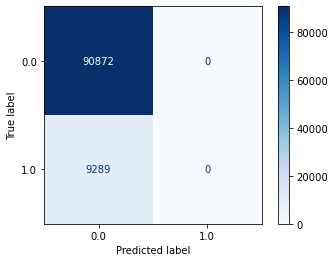

In [58]:
#DEBUG, REMOVE THIS DURING PRODUCTION
def create_confusion_matrix(y_test, y_pred, x_test, clf):
    confusion_matrix(y_test, int_pred)
    plot_confusion_matrix(clf, x_test, y_test, cmap=plt.cm.Blues)
    plt.show()


f1_score(y_test, int_pred, average='weighted')

create_confusion_matrix(y_test, int_pred, x_test, clf)

In [99]:
#DEBUG, REMOVE THIS DURING PRODUCTION
print(np.sum(y_test))
print(len(y_test))
print(np.sum(int_pred))
print(len(int_pred))

print(np.sum(y_test)/len(y_test)*100)

9289.0
100161
0.0
100161
9.274068749313605


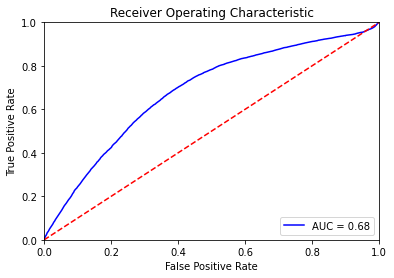

In [38]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Goal Rate

In [14]:
# utility function
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [112]:
x_test_s, y_test_s = zip(*sorted(zip(x_test, y_test)))

In [160]:
def prepare_goal_rate(y_array):
    x_test_sorted = x_test.copy()
    x_test_sorted.sort()
    res = split(y_array, 101)
    built_array = []
    index_array = []
    counter = 100
    total_goal = 0
    goal_array = []
    for i in res:
        sub_len = len(i)
        sub_res  = i
        sub_res_np = np.array(sub_res)
        goals = np.count_nonzero(sub_res_np)
        shots = sub_res_np.size - np.count_nonzero(sub_res_np)
        sub_final = goals / (shots - goals)
        goal_array.append(goals)
        total_goal = total_goal + goals
        built_array.append(sub_final*100)

        index_array.append(counter)
        counter = counter - 1
    
    return built_array, index_array, goal_array, total_goal

built_array, index_array, goal_array, total_goal = prepare_goal_rate(y_test_s)

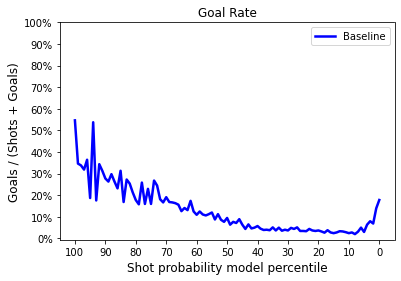

In [161]:
def create_goal_rate_plot(index_array, built_array):
    fig, ax = plt.subplots()
    ax.plot(index_array, built_array, color="blue", linewidth=2.5)
    plt.xticks(np.arange(min(index_array), max(index_array)+1, 10.0))
    plt.yticks(np.arange(0, 110, 10.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.invert_xaxis()
    ax.legend(['Baseline'])
    plt.title("Goal Rate")
    plt.xlabel('Shot probability model percentile', fontsize=12)
    plt.ylabel('Goals / (Shots + Goals)', fontsize=12)
    plt.show()

create_goal_rate_plot(index_array, built_array)

Cumulative % of Goals

In [162]:
def compute_cumulative(goal_array, total_goal):
    cumulative_array = []
    last_elem = 0
    for i in goal_array:
        if total_goal != 0:
            current = i / total_goal*100 + last_elem
        else:
            current = last_elem
        cumulative_array.append(current)
        
        last_elem = current
    return cumulative_array

cumulative_array = compute_cumulative(goal_array, total_goal)

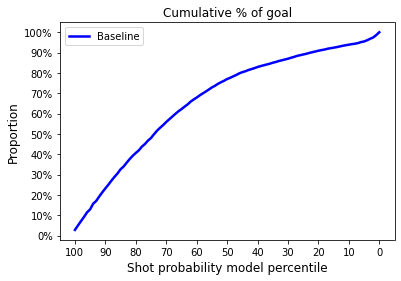

In [163]:
def create_cumulative_plot(index_array, cumulative_array):
    fig, ax = plt.subplots()
    ax.plot(index_array, cumulative_array, color="blue", linewidth=2.5)
    plt.xticks(np.arange(min(index_array), max(index_array)+1, 10.0))
    plt.yticks(np.arange(0, 110, 10.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.invert_xaxis()
    ax.legend(['Baseline'])
    plt.title("Cumulative % of goal")
    plt.xlabel('Shot probability model percentile', fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.show()

create_cumulative_plot(index_array, cumulative_array)

Calibration

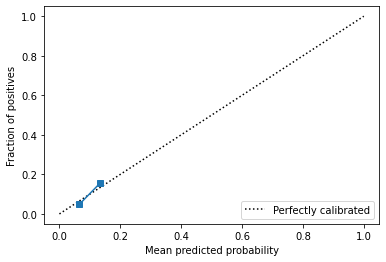

In [47]:
prob_true, prob_pred = calibration_curve(y_test, preds, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, preds)
disp.plot()

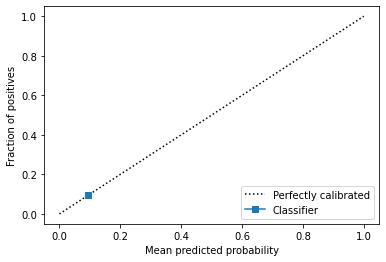

In [48]:
disp = CalibrationDisplay.from_predictions(y_test, preds)
plt.show()

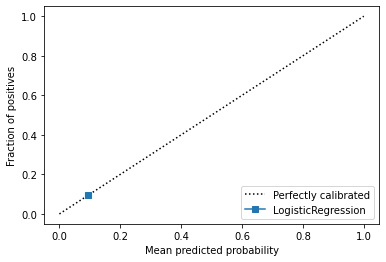

In [49]:
disp = CalibrationDisplay.from_estimator(clf, x_test, y_test)
plt.show()

Modèle 2 : angle 

In [164]:
df_filtered_2 = df_dropped[['isGoal', 'angleWithGoal']]
df_filtered_2.head(5)

,isGoal,angleWithGoal
0,0.0,10.007980
1,0.0,0.000000
2,0.0,4.085617
3,0.0,46.636577
4,0.0,2.045408


In [165]:
print(df_filtered_2['angleWithGoal'].isnull().sum())
print(df_filtered_2['isGoal'].isnull().sum())

0
0


In [166]:
df_filtered_2 = df_filtered_2.dropna(subset=['angleWithGoal'])
print(df_filtered_2['angleWithGoal'].isnull().sum())

0


In [167]:
train, test = train_test_split(df_filtered_2, test_size=0.33, random_state=42)
print(train.shape)
print(test.shape)

(203357, 2)
(100161, 2)


In [168]:
x1 = train[['angleWithGoal']].to_numpy().reshape(-1, 1)

y1 = train['isGoal'].to_numpy()

x1_test = test[['angleWithGoal']].to_numpy().reshape(-1, 1)

y1_test = test['isGoal'].to_numpy()

In [169]:
# instanciate a logistic regression model
clf = LogisticRegression()

# train model
clf.fit(x1, y1)

# score model
clf.score(x1_test, y1_test)

0.907259312506864

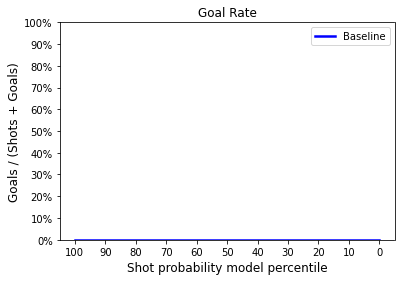

ZeroDivisionError: division by zero

In [170]:
y_array = clf.predict(x_test)
built_array, index_array, goal_array, total_goal = prepare_goal_rate(y_array)
create_goal_rate_plot(index_array, built_array)
cumulative_array = compute_cumulative(goal_array, total_goal)
create_cumulative_plot(index_array, cumulative_array)

Modèle 3 : angle + distance

In [ ]:
df_filtered_3 = df_dropped[['isGoal', 'distanceToGoal', 'angleWithGoal']]
df_filtered_3.head(5)

In [ ]:
print(df_filtered_3['angleWithGoal'].isnull().sum())
print(df_filtered_3['distanceToGoal'].isnull().sum())
print(df_filtered_3['isGoal'].isnull().sum())

In [ ]:
df_filtered_3 = df_filtered_3.dropna(subset=['angleWithGoal'])
print(df_filtered_3['angleWithGoal'].isnull().sum())

In [ ]:
train, test = train_test_split(df_filtered_3, test_size=0.33, random_state=42)
print(train.shape)
print(test.shape)

In [ ]:
x2 = train[['distanceToGoal', 'angleWithGoal']].to_numpy().reshape(-1, 2)

y2 = train['isGoal'].to_numpy()

x2_test = test[['distanceToGoal', 'angleWithGoal']].to_numpy().reshape(-1, 2)

y2_test = test['isGoal'].to_numpy()

In [ ]:
# instanciate a logistic regression model
clf = LogisticRegression()

# train model
clf.fit(x2, y2)

# score model
clf.score(x2_test, y2_test)